# Adaptive Intelligence COM3240

#### Script that returns the learnign curve for each trial

In [220]:
import numpy as np
import scipy.spatial.distance as dist

def Start(N, M):
    return np.array([np.random.randint(N), np.random.randint(M)])   #random start

def homing_nn(n_trials, learning_rate, eps, gamma, max_steps=50, count_min_steps=False, count_actions=False, diagonal=False):

    # Solving homing task with on-policy TD (SARSA)


    ## Definition of the environment
    N = 3                               #height of the gridworld ---> number of rows
    M = 4                              #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    states_matrix = np.eye(N_states)
    if diagonal:
        #                              N  NE   E  SE   S  SW   W  NW
        action_row_change = np.array([-1, -1,  0, +1, +1, +1,  0, -1])
        action_col_change = np.array([ 0, +1, +1, +1,  0, -1, -1, +1])
    else:
        #                              N   E   S   W
        action_row_change = np.array([-1,  0, +1,  0])#number of cell shifted in vertical as a function of the action
        action_col_change = np.array([ 0, +1,  0, -1])#number of cell shifted in horizontal as a function of the action
    N_actions = action_row_change.shape[0]
    End = np.array([1, 1])                                  #terminal state--->reward
    s_end = np.ravel_multi_index(End, dims = (N, M), order = 'F')  #terminal state. Conversion in single index

    ## Parameters of the model
    #gamma = 0.9                        #discounting factor
    #learning_rate = 0.5                #constant step-size parameter (learning rate)
    #eps = 0.0                          #epsilon-greedy SARSA

    ## Rewards
    R = 10                              #only when the robot reaches the charger, sited in End state

    ## Variables
    weights = np.random.rand(N_actions, N_states)
    learning_curve = np.zeros((1 + count_min_steps, n_trials))
    if count_actions:
        pref_actions = []

    ## SARSA

    # Start trials
    for trial in range(n_trials):

        # Initialization
        Start_mat = Start(N, M)
        s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')      #conversion in single index
        
        #Make sure the robot doesn't start on the goal
        while s_start == s_end:
            Start_mat = Start(N, M)
            s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')
        state = Start_mat                                                   #set current state
        s_index = s_start      
        step = 0
        
        #Manhattan Distance between start and end
        if count_min_steps:
            min_steps = dist.cityblock(Start_mat, End)
            learning_curve[1, trial]= min_steps
        # Start steps
        trial_pref_actions = []
        while s_index != s_end and step <= max_steps:
            step += 1
            learning_curve[0, trial]= step

            input_vector = states_matrix[:, s_index].reshape(N_states, 1)         #convert the state into an input vector

            #compute Qvalues. Qvalue = logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig

            #eps-greedy policy implementation
            greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
            if greedy:
                action = np.argmax(Q)                           #pick best action
            else:
                action = np.random.randint(N_actions)           #pick random action
            if count_actions:
                trial_pref_actions += [action]

            state_new = np.array([0, 0])
            #move into a new state
            state_new[0]= state[0] + action_row_change[action]
            state_new[1]= state[1] + action_col_change[action]

            #initialise reward
            r = 0
            
            #put the robot back in grid if it goes out.
            lt_x = state_new[0] < 0
            if lt_x:
                state_new[0]= 0
            gt_x = state_new[0] >= N
            if gt_x:
                state_new[0]= N-1
            lt_y = state_new[1] < 0
            if lt_y:
                state_new[1]= 0
            gt_y = state_new[1] >= M
            if gt_y:
                state_new[1]= M-1
            #give a negative reward
            if lt_x or gt_x or lt_y or gt_y:
                r = -1
            
            s_index_new = np.ravel_multi_index(state_new, dims = (N, M), order = 'F')  #conversion in a single index

            #if is not the first step
            if step > 1: 
                #update Qvalues
                weights += learning_rate * (r_old + gamma * Q[action] - Q_old) * output_old.dot(input_old.T)

            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions, 1))
            output[action]= 1

            #update variables
            input_old = input_vector
            output_old = output
            Q_old = Q[action]
            r_old = r

            state[0]= state_new[0]
            state[1]= state_new[1]
            s_index = s_index_new

            ## check if state is terminal and update the weights consequently
            if s_index == s_end:
                weights += learning_rate * (R - Q_old) * output_old.dot(input_old.T)
                pass
        if count_actions:
            pref_actions += [trial_pref_actions]

    return (learning_curve, pref_actions) if count_actions else learning_curve


#### Call the function homing_nn


{'North': [108], 'Northeast': [19], 'East': [21], 'Southeast': [19], 'South': [31], 'Southwest': [86], 'West': [30], 'Northwest': [11]}


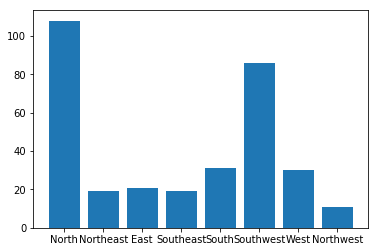

(2, 100)
[[ 18.  20.  44.   3.  15.  24.   7.   1.   6.   3.   8.   3.   1.   2.
    1.   1.   4.   2.   3.   2.   2.   2.   1.   2.   1.   2.   3.   3.
    1.   3.   3.   1.   2.   1.   3.   1.   3.   4.   2.   1.   1.   2.
    4.   1.   1.   2.   2.   2.   2.   3.   1.   3.   1.   1.   3.   3.
    1.   1.   2.   3.   2.   1.   1.   3.   1.   1.   1.   2.   1.   1.
    2.   4.   3.   1.   1.   1.   1.   2.   3.   1.   1.   2.   4.   2.
    3.   2.   4.   2.   4.   1.   2.   3.   2.   1.   2.   1.   2.   3.
    1.   2.]
 [  2.   2.   2.   3.   3.   3.   2.   1.   2.   1.   1.   2.   2.   2.
    2.   1.   3.   2.   1.   1.   1.   2.   2.   2.   1.   1.   2.   2.
    2.   1.   3.   2.   1.   2.   3.   1.   2.   3.   2.   1.   1.   1.
    3.   2.   2.   1.   1.   2.   2.   1.   1.   1.   1.   2.   3.   2.
    1.   2.   1.   3.   1.   2.   2.   2.   2.   2.   2.   1.   2.   2.
    1.   3.   3.   2.   1.   2.   1.   2.   3.   2.   2.   1.   3.   2.
    2.   1.   3.   1.   3.   2.   2.   1. 

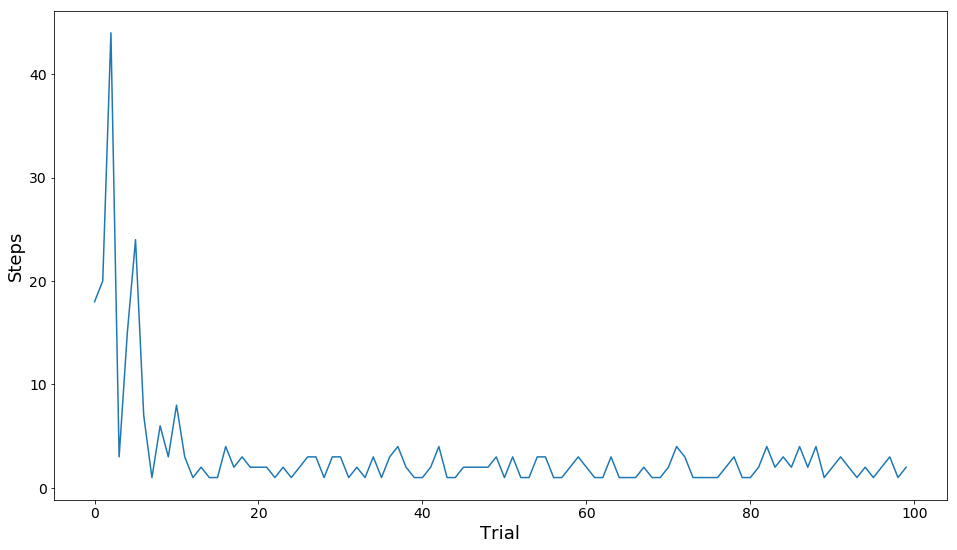

In [221]:
#We will call this procedure one run of the algorithm.
n_trials = 100
learning_rate=0.5                #constant step-size parameter (learning rate)
eps=0.0                          #epsilon-greedy SARSA
gamma=0.9                        #discounting factor
c_min_steps = True
c_actions = True
diag = True
import matplotlib.pyplot as plt
l_curve=homing_nn(n_trials,learning_rate,eps,gamma, count_min_steps=c_min_steps, count_actions=c_actions, diagonal=diag)
if c_actions:
    if diag:
        actions_dict = dict(zip(['North',
                                 'Northeast',
                                 'East',
                                 'Southeast', 
                                 'South', 
                                 'Southwest', 
                                 'West', 
                                 'Northwest'],
                                [[],[],[],[],[],[],[],[]]))
    else:
        actions_dict = dict(zip(['North','East','South','West'],[[],[],[],[]]))
    flat_pref_actions = [action_n for sublist in l_curve[1] for action_n in sublist]
    l_curve = l_curve[0]
    actions_dict['North'] +=[flat_pref_actions.count(0)]
    if diag:
        actions_dict['Northeast'] +=[flat_pref_actions.count(1)]
        actions_dict['East']  +=[flat_pref_actions.count(2)]
        actions_dict['Southeast'] +=[flat_pref_actions.count(3)]
        actions_dict['South'] +=[flat_pref_actions.count(4)]
        actions_dict['Southwest'] +=[flat_pref_actions.count(5)]
        actions_dict['West']  +=[flat_pref_actions.count(6)]
        actions_dict['Northwest'] +=[flat_pref_actions.count(7)]
    else:
        actions_dict['East']  +=[flat_pref_actions.count(1)]
        actions_dict['South'] +=[flat_pref_actions.count(2)]
        actions_dict['West']  +=[flat_pref_actions.count(3)]
    print(actions_dict)
    plt.bar(range(len(actions_dict)), [np.mean(l) for l in actions_dict.values()], align='center')
    plt.xticks(range(len(actions_dict)), list(actions_dict.keys()))
    plt.show()
    
print(l_curve.shape)
print(l_curve)
fontsize=18
plt.figure(figsize=(16, 9))
plt.plot(l_curve[0].T)
plt.xlabel('Trial',fontsize=fontsize)
plt.ylabel('Steps',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

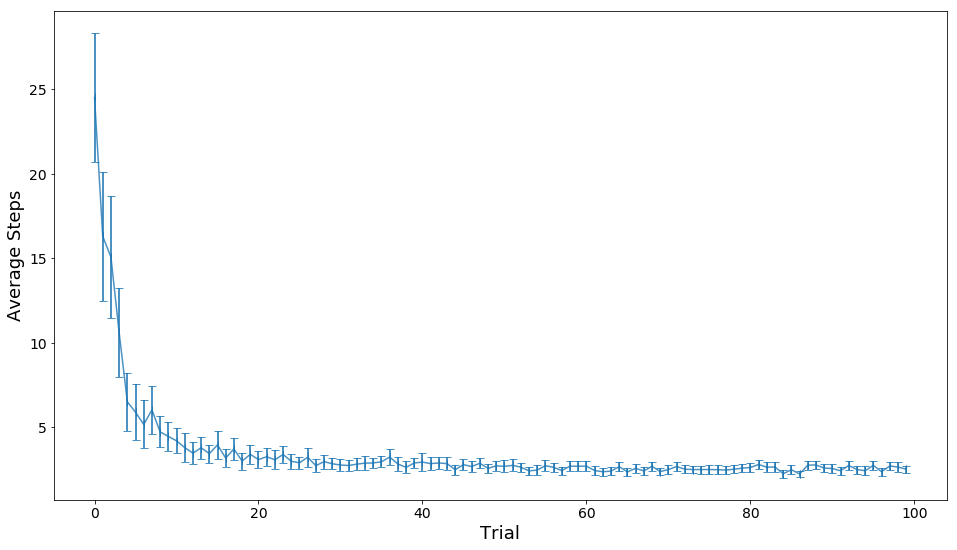

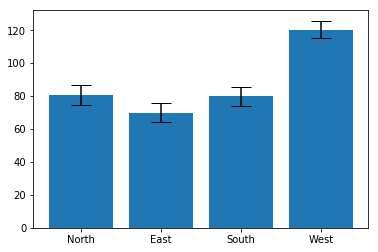

In [222]:
#produce a curve that is the average of the learning curves of the individual runs.
def manyruns(n_trials,learning_rate,eps,gamma, max_steps=50, count_min_steps=False, count_actions=False):
    runs=100
    total_steps=np.zeros((runs,n_trials))
    if count_actions:
        actions_dict = dict(zip(['North','East','South','West'],[[],[],[],[]]))
    for j in range(runs):
        l_curve=homing_nn(n_trials,learning_rate,eps,gamma,max_steps,count_min_steps,count_actions)
        if count_actions:
            flat_pref_actions = [action_n for sublist in l_curve[1] for action_n in sublist]
            l_curve = l_curve[0]
            actions_dict['North'] +=[flat_pref_actions.count(0)]
            actions_dict['East']  +=[flat_pref_actions.count(1)]
            actions_dict['South'] +=[flat_pref_actions.count(2)]
            actions_dict['West']  +=[flat_pref_actions.count(3)]
        total_steps[j,:]=l_curve[0].T
    
    plt.figure(figsize=(16, 9))
    means=np.mean(total_steps, axis=0)
    errors=2*np.std(total_steps, axis=0)/np.sqrt(runs)
    plt.errorbar(np.arange(n_trials), means, errors, 0, elinewidth=2, capsize=4, alpha=0.8)
    plt.xlabel('Trial',fontsize=fontsize)
    plt.ylabel('Average Steps',fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
    if count_actions:
        #plt.bar(range(len(actions_dict)), [np.mean(l) for l in actions_dict.values()], align='center')
        actions_errors=[2*np.std(l, axis=0)/np.sqrt(runs) for l in actions_dict.values()]
        plt.bar(range(len(actions_dict)), [np.mean(l) for l in actions_dict.values()], yerr=actions_errors, align='center', ecolor='black', capsize=10)
        plt.xticks(range(len(actions_dict)), list(actions_dict.keys()))
        plt.show()
manyruns(n_trials,learning_rate,eps,gamma,count_actions=True)

In [223]:
""" Minimise total difference between the actual number of steps and the total number of steps subject to learning_rate, eps,
    and gamma all between 0 and 1 inclusive."""
from scipy.optimize import minimize
from tabulate import tabulate
def to_optimise(aeg, diagonal=False):
    lc = homing_nn(n_trials,
                   aeg[0],
                   aeg[1],
                   aeg[2],
                   count_min_steps=True, diagonal=diagonal)
    equal = sum(i!=j for i,j in lc.T)
    return equal

In [224]:
cons = ({'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]},
        {'type': 'ineq', 'fun': lambda x:  1-x[0]},
        {'type': 'ineq', 'fun': lambda x:  1-x[1]},
        {'type': 'ineq', 'fun': lambda x:  1-x[2]})

opt_runs = 25
params_dict = dict(zip(['alpha', 'epsilon', 'gamma'],[[],[],[]]))
params = [learning_rate, eps,gamma] #Initial Guess
threshold = 10
max_iter = 25
for j in range(opt_runs):
    print(j)
    inequalities = 100
    params_arr=[]
    i = 0
    while (inequalities > threshold):
        i += 1
        res = minimize(to_optimise, params, method='COBYLA', constraints=cons, tol=1e-6)
        if res.fun < inequalities:
            inequalities = res.fun
            params = res.x
        if i ==max_iter:
            print("Maximum iterations reached")
            break
        params_arr += [params]
    params_arr = np.pad(params_arr,  [(0, max_iter-i), (0, 0)], 'edge')
    params_dict['alpha'] +=[params_arr.T[0]]
    params_dict['epsilon'] += [params_arr.T[1]]
    params_dict['gamma'] += [params_arr.T[2]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


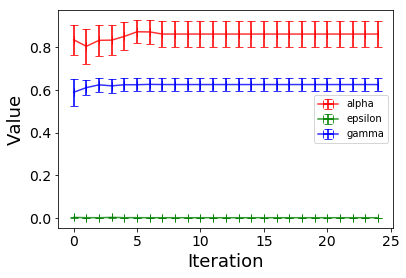

In [225]:
def opt_means(param_name):
    return [np.mean(l) for l in np.array(params_dict[param_name]).T]
def opt_sems(param_name):
    return [2*np.std(l, axis=0)/np.sqrt(opt_runs) for l in np.array(params_dict[param_name]).T]
alpha_plot=plt.errorbar(np.arange(opt_runs), opt_means('alpha'), opt_sems('alpha'), 0, elinewidth=2, capsize=4, alpha=0.8, color='r',label='alpha')
epsilon_plot=plt.errorbar(np.arange(opt_runs), opt_means('epsilon'), opt_sems('epsilon'), 0, elinewidth=2, capsize=4, alpha=0.8, color='g',label='epsilon')
gamma_plot=plt.errorbar(np.arange(opt_runs), opt_means('gamma'), opt_sems('gamma'), 0, elinewidth=2, capsize=4, alpha=0.8, color='b',label='gamma')
plt.legend(handles=[alpha_plot, epsilon_plot, gamma_plot])
plt.xlabel('Iteration',fontsize=fontsize)
plt.ylabel('Value',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


\overline{\alpha} &= 0.862582 \pm 0.061709\\
\overline{\epsilon} &= 0.000127 \pm 0.000131\\
\overline{\gamma} &= 0.625481 \pm 0.030302\\


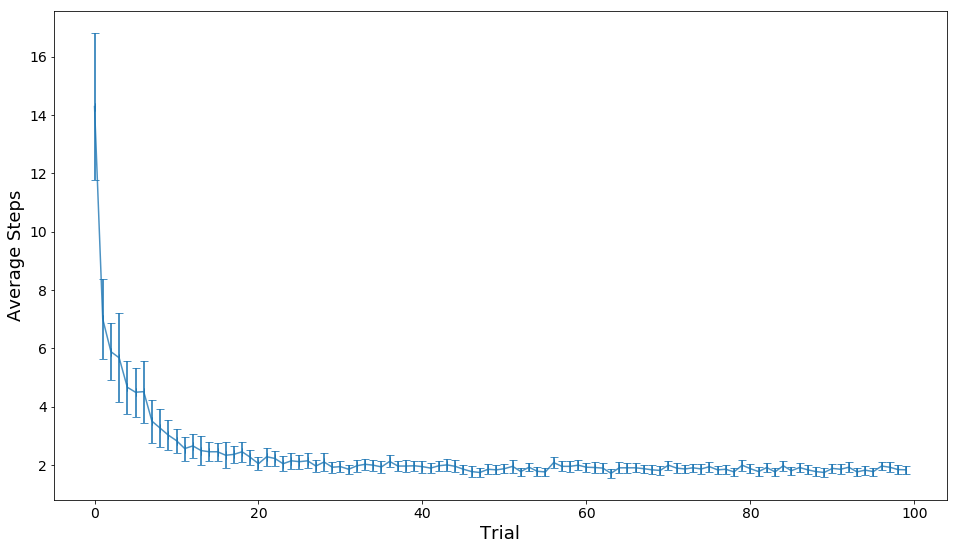

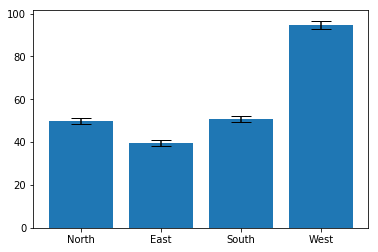

In [226]:
final_params = []
for k in params_dict.keys():
    foo_bar = np.round(opt_means(k)[-1],6)
    foo_sem = np.round(opt_sems(k)[-1],6)
    final_params += [foo_bar]
    print("\overline{\\" + k + "}", '&=', str(foo_bar),'\pm',str(foo_sem)+"\\\\")
manyruns(n_trials, *tuple(final_params),count_actions=True)

In [227]:
print("\o")

\o
